This code is developed by "Fatemehzahed kachaee" based on "Hamiltonian Neural Networks by
Sam Greydanus, Misko Dzamba, Jason Yosinski"

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import autograd
import pandas as pd
np.random.seed(0)

In [9]:
def grad_Hamiltonian(t,r):
    k,m=1,1
    q, p = r 
    tfq = tf.Variable(q, dtype='float64')
    tfp = tf.Variable(p, dtype='float64')

    with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
        tape0.watch(tfq)
        tape1.watch(tfp)

        h1 = 1-tf.math.cos(tfq)
        h2 = tfp**2
        dHdq=tape0.gradient(h1, tfq)
        dHdp=tape1.gradient(h2, tfp)
        S = np.array([dHdp, -dHdq])
    return S
        

# trajectory

def trajectory(t,y0):
   
    noise_std=0.1
    sol = integrate.solve_ivp(fun=grad_Hamiltonian,t_span=t,y0=y0,t_eval=np.linspace(0,10,100))
    q_new,p_new=sol.y
    
    dydt = [grad_Hamiltonian( None,y) for y in sol['y'].T]
    dydt = np.stack(dydt).T
    dq, dp = np.split(dydt,2)
    # add noise
    q_new += np.random.randn(*q_new.shape)*noise_std
    p_new += np.random.randn(*p_new.shape)*noise_std
    return q_new,p_new,dq,dp


In [10]:
def get_dataset(seed=0, samples=50, test_split=0.2):    # inja 50ta nemune random az file data bardashte be surste zoje moratab p&q va dp&dq neveshte va 20 darsad oona ro dade test ghara dade
    data = {'meta': locals()}
    t=[0,10]
    y0=np.asarray([1.0,0.0])
    # randomly sample inputs
    np.random.seed(seed)
    xs, dxs = [], []
    for s in range(samples):
        q, p, dq, dp= trajectory(t,y0)
        xs.append( np.stack( [q, p]).T )
        dxs.append( np.stack( [dq, dp]).T )
        
    data['q&p'] = np.concatenate(xs)
    data['dq&dp'] = np.concatenate(dxs).squeeze()

    # make a train/test split
    split_ix = int(len(data['q&p']) * test_split)
    split_data = {}
    for k in ['q&p', 'dq&dp']:
        split_data[k], split_data['test_' + k] = data[k][:split_ix], data[k][split_ix:]
    data = split_data
    return data

In [11]:
data = get_dataset()
x_train = tf.constant(data['q&p'], dtype=tf.float32)
x_test = tf.constant( data['test_q&p'], dtype=tf.float32)
y_train = tf.constant(data['dq&dp'])
y_test = tf.constant(data['test_dq&dp'])

In [12]:
myModel=keras.models.Sequential()
myModel.add(keras.layers.Flatten(input_shape=[2]))
myModel.add(keras.layers.Dense(200, activation="tanh"))
myModel.add(keras.layers.Dropout(0.2))
myModel.add(keras.layers.Dense(200, activation="tanh"))
myModel.add(keras.layers.Dropout(0.2))
myModel.add(keras.layers.Dense(2))#, activation="sigmoid"))

myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2)                 0         
_________________________________________________________________
dense (Dense)                (None, 200)               600       
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 402       
Total params: 41,202
Trainable params: 41,202
Non-trainable params: 0
____________________________________________________

In [13]:
myModel.compile(loss=tf.keras.losses.MeanAbsoluteError(),#loss
                optimizer=keras.optimizers.Adam(lr=1e-4),
                metrics=["accuracy"])

trainedModel=myModel.fit(x_train,y_train, epochs=15
                        ,validation_split=(0.2))

Epoch 1/15
25/25 [==============================] - 0s 11ms/step - loss: 0.5659 - accuracy: 0.8413 - val_loss: 0.3998 - val_accuracy: 0.8650
Epoch 2/15
25/25 [==============================] - 0s 4ms/step - loss: 0.3147 - accuracy: 0.8587 - val_loss: 0.2199 - val_accuracy: 0.9150
Epoch 3/15
25/25 [==============================] - 0s 4ms/step - loss: 0.1922 - accuracy: 0.9287 - val_loss: 0.1185 - val_accuracy: 0.9550
Epoch 4/15
25/25 [==============================] - 0s 4ms/step - loss: 0.1438 - accuracy: 0.9337 - val_loss: 0.1112 - val_accuracy: 0.9600
Epoch 5/15
25/25 [==============================] - 0s 4ms/step - loss: 0.1437 - accuracy: 0.9362 - val_loss: 0.1127 - val_accuracy: 0.9600
Epoch 6/15
25/25 [==============================] - 0s 3ms/step - loss: 0.1443 - accuracy: 0.9413 - val_loss: 0.1099 - val_accuracy: 0.9600
Epoch 7/15
25/25 [==============================] - 0s 4ms/step - loss: 0.1446 - accuracy: 0.9350 - val_loss: 0.1117 - val_accuracy: 0.9600
Epoch 8/15
25/25 [=

<AxesSubplot:>

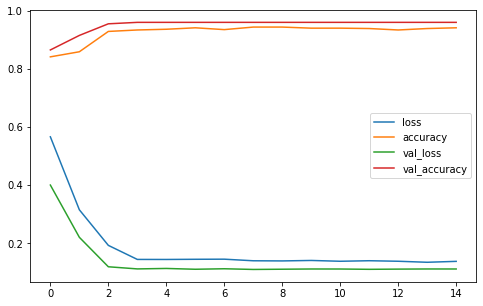

In [14]:
pd.DataFrame(trainedModel.history).plot(figsize=(8, 5))

In [15]:
myModel.evaluate(x_test, y_test)

125/125 [==============================] - 0s 2ms/step - loss: 0.1127 - accuracy: 0.9638


[0.11272046715021133, 0.9637500047683716]

In [16]:
def pred_pdot_qdot(t,r):
    q,p = r 
    new_init_val= np.array([[q,p]])
    y=myModel.predict(new_init_val)[0]
    return(y[0],y[1])

In [17]:
def Data(t,y0):
    noise_std=0.1
    sol = integrate.solve_ivp(fun=pred_pdot_qdot,t_span=t,y0=y0,t_eval=np.linspace(0,30,300))
    q_new,p_new=sol.y
    
    dydt = [grad_Hamiltonian( None,y) for y in sol['y'].T]
    dydt = np.stack(dydt).T
    dq, dp = np.split(dydt,2)
    return q_new,p_new,dq,dp
    return q_new,p_new,dq,dp

In [18]:
t=(0,30)
init_val=np.asarray([1.0,0.0])
pred_p,pred_q,pred_pdot,pred_qdot=Data(t,init_val)

In [19]:
a,b=np.transpose(x_train)
qt,uselesq=np.split(a,[300])
pt,uselesp=np.split(b,[300])

Text(0, 0.5, 'q')

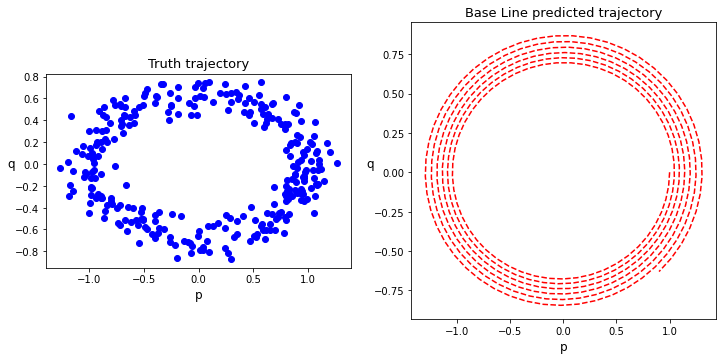

In [20]:
x,y=np.transpose(x_train)
xx,yy=np.transpose(y_train)

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.plot(qt,pt,'bo')
plt.axis('scaled')
plt.title('Truth trajectory', fontsize=13)
plt.xlabel('p', fontsize=12)
plt.ylabel('q',rotation=0, fontsize=12)

plt.subplot(222)
plt.plot(pred_p,pred_q,'r--')
plt.title('Base Line predicted trajectory', fontsize=13)
plt.xlabel('p', fontsize=12)
plt.ylabel('q',rotation=0, fontsize=12)



In [21]:
Ht=qt**2+pt**2
Hp=pred_q**2+pred_p**2

In [22]:
meanE=np.mean(Ht)*np.ones(len(qt))
pmeanE=np.mean(Hp)*np.ones(len(pred_p))

Text(0, 0.5, '$H$')

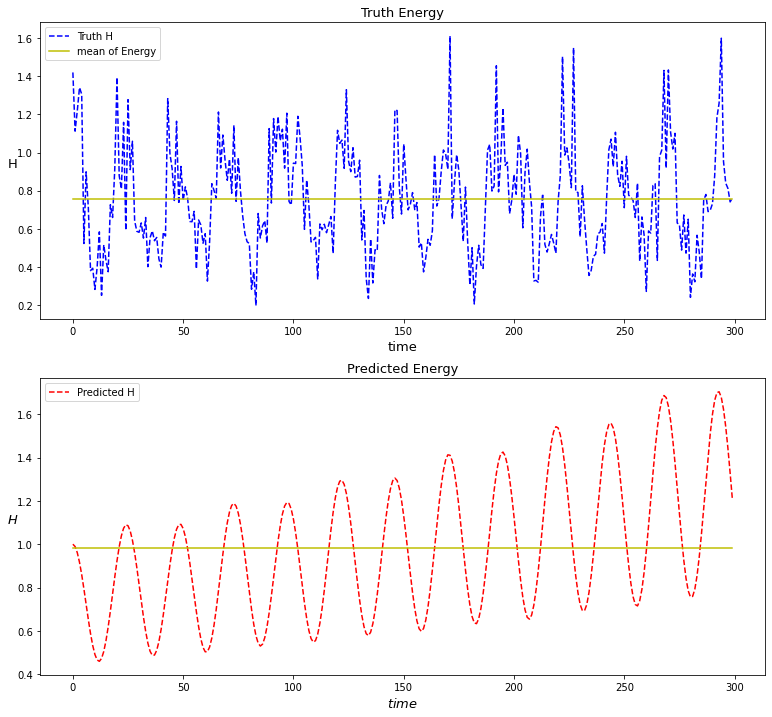

In [23]:
plt.figure(figsize=(13,12))

plt.subplot(211)
plt.plot(Ht,'b--')
plt.plot(meanE,'y')
plt.title('Truth Energy', fontsize=13)
plt.xlabel('time', fontsize=13)
plt.ylabel('H',rotation=0, fontsize=13)
plt.legend(['Truth H','mean of Energy'])

plt.subplot(212)
plt.plot(Hp,'r--')
plt.plot(pmeanE,'y')
plt.title('Predicted Energy', fontsize=13)
plt.legend(['Predicted H'])
plt.xlabel('$time$', fontsize=13)
plt.ylabel('$H$',rotation=0, fontsize=13)


